In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from termcolor import colored

In [2]:
data = pd.read_csv('../dataset/preprocessed.csv')
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes Sent,Bytes Received,Elapsed Time (sec)
0,57222,53,54587,53,allow,94,83,30
1,56258,3389,56258,3389,allow,1600,3168,17
2,6881,50321,43265,50321,allow,118,120,1199
3,50553,3389,50553,3389,allow,1438,1889,17
4,50002,443,45848,443,allow,6778,18580,16


In [3]:
Y = data['Action']
X = data.drop(['Action'], axis=1)
feature_names = X.columns.tolist()
X.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes Sent,Bytes Received,Elapsed Time (sec)
0,57222,53,54587,53,94,83,30
1,56258,3389,56258,3389,1600,3168,17
2,6881,50321,43265,50321,118,120,1199
3,50553,3389,50553,3389,1438,1889,17
4,50002,443,45848,443,6778,18580,16


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

In [6]:
# Prekopirano sa vezbi

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['allow', 'drop', 'deny', 'reset-both'], index=['allow', 'drop', 'deny', 'reset-both']))
    print("---------------------------------------------------------------------------------")
    

def plot_decision_tree(model, feature_names):
    plt.figure(figsize=(7, 7))
    plot_tree(model, class_names=['allow', 'drop', 'deny', 'reset-both'], feature_names=feature_names, filled=True)
    plt.title("Decision tree of depth {} with {} nodes".format(model.get_depth(), model.get_n_leaves()))

    plt.show()
    print("---------------------------------------------------------------------------------")
    print(colored("Parameters of model {}".format(type(model).__name__), "green"))
    for k, v in model.get_params().items():
        print(colored(k, 'blue'), v)
    
    print("---------------------------------------------------------------------------------")

In [7]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

DecisionTreeClassifier()

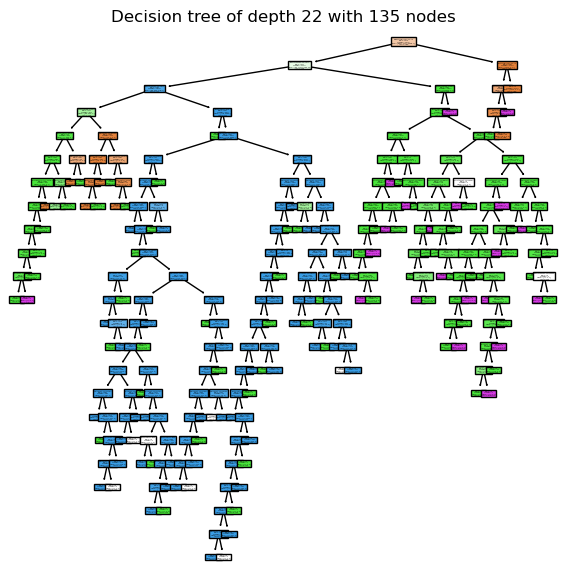

---------------------------------------------------------------------------------
Parameters of model DecisionTreeClassifier
ccp_alpha 0.0
class_weight None
criterion gini
max_depth None
max_features None
max_leaf_nodes None
min_impurity_decrease 0.0
min_samples_leaf 1
min_samples_split 2
min_weight_fraction_leaf 0.0
random_state None
splitter best
---------------------------------------------------------------------------------


In [8]:
plot_decision_tree(dtc, feature_names)

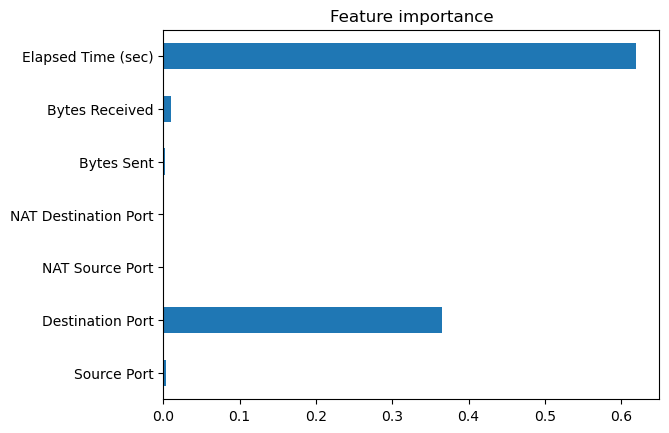

In [9]:
pd.Series(dtc.feature_importances_, index=X.columns).plot.barh()
plt.title("Feature importance")
plt.show()

In [10]:
report(dtc, X_train, Y_train)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     28227
        deny       1.00      1.00      1.00     11240
        drop       1.00      1.00      1.00      9638
  reset-both       1.00      1.00      1.00        41

    accuracy                           1.00     49146
   macro avg       1.00      1.00      1.00     49146
weighted avg       1.00      1.00      1.00     49146

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
            allow   drop  deny  reset-both
allow       28220      7     0           0
drop            0  11240     0           0
deny            0      6  9632           0
reset-b

In [11]:
report(dtc, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9410
        deny       0.99      1.00      1.00      3747
        drop       1.00      1.00      1.00      3213
  reset-both       0.70      0.54      0.61        13

    accuracy                           1.00     16383
   macro avg       0.92      0.88      0.90     16383
weighted avg       1.00      1.00      1.00     16383

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
---------------------------------------------------------------------------------
            allow  drop  deny  reset-both
allow        9406     3     0           1
drop            1  3737     7           2
deny            0    12  3201           0
reset-both      0  

In [12]:
# GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [12,15,18,20,None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'splitter': ['best', 'random']
}

estimator = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid=param_grid, cv=3)
estimator.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [12, 15, 18, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [13]:
print(estimator.best_params_, '\n')
print(estimator.best_score_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'} 

0.9978024661213527


In [14]:
report(estimator.best_estimator_, X_train, Y_train)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     28227
        deny       1.00      1.00      1.00     11240
        drop       1.00      1.00      1.00      9638
  reset-both       0.72      1.00      0.84        41

    accuracy                           1.00     49146
   macro avg       0.93      1.00      0.96     49146
weighted avg       1.00      1.00      1.00     49146

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 
---------------------------------------------------------------------------------
            allow   drop  deny  reset-both
allow       28217     10     0           0
drop            0  11194    30          16
deny            0      1  9637           0
reset-b

In [15]:
report(estimator.best_estimator_, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9410
        deny       1.00      1.00      1.00      3747
        drop       1.00      1.00      1.00      3213
  reset-both       0.35      0.46      0.40        13

    accuracy                           1.00     16383
   macro avg       0.84      0.86      0.85     16383
weighted avg       1.00      1.00      1.00     16383

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
---------------------------------------------------------------------------------
            allow  drop  deny  reset-both
allow        9406     3     0           1
drop            0  3729     8          10
deny            0     0  3213           0
reset-both      0  

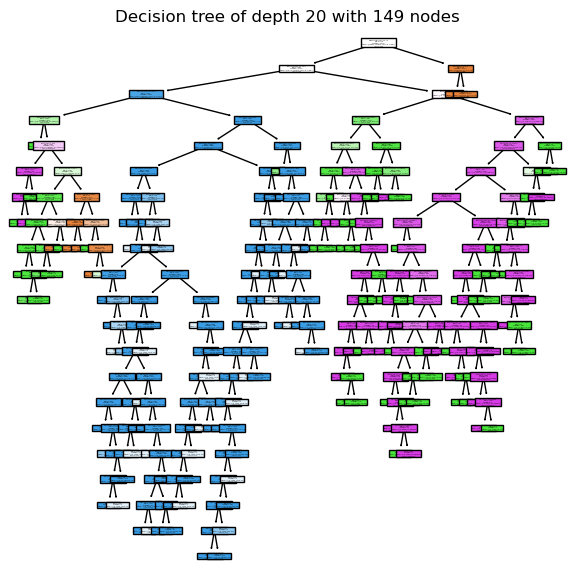

---------------------------------------------------------------------------------
Parameters of model DecisionTreeClassifier
ccp_alpha 0.0
class_weight balanced
criterion gini
max_depth 20
max_features None
max_leaf_nodes None
min_impurity_decrease 0.0
min_samples_leaf 2
min_samples_split 2
min_weight_fraction_leaf 0.0
random_state None
splitter best
---------------------------------------------------------------------------------


In [16]:
plot_decision_tree(estimator.best_estimator_, feature_names)

In [17]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [18]:
report(random_forest, X_train, Y_train)

Classification report for model RandomForestClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     28227
        deny       1.00      1.00      1.00     11240
        drop       1.00      1.00      1.00      9638
  reset-both       1.00      1.00      1.00        41

    accuracy                           1.00     49146
   macro avg       1.00      1.00      1.00     49146
weighted avg       1.00      1.00      1.00     49146

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on training data 
---------------------------------------------------------------------------------
            allow   drop  deny  reset-both
allow       28220      7     0           0
drop            0  11234     6           0
deny            0      0  9638           0
reset-b

In [19]:
report(random_forest, X_test, Y_test, "test")

Classification report for model RandomForestClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      9410
        deny       0.99      1.00      1.00      3747
        drop       1.00      1.00      1.00      3213
  reset-both       0.75      0.23      0.35        13

    accuracy                           1.00     16383
   macro avg       0.94      0.81      0.84     16383
weighted avg       1.00      1.00      1.00     16383

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on test data 
---------------------------------------------------------------------------------
            allow  drop  deny  reset-both
allow        9406     3     0           1
drop            0  3740     7           0
deny            0    11  3202           0
reset-both      0  